# Unt type sampling bias

author: steeve.laquitaine@epfl.ch  

**methods**:
* We focus on single-units
* multi-units have not one type by definition.

**conclusion**:
* **strong sampling bias**: single-unit excitatory cADpyr from L5,6 then L2/3 and 4 are preferentially captured by all spike sorters. INH units are strongly undersampled.
* All tested spike sorters share the same sampling bias.

**next**:
* what is effect of this sampling bias on the circuit's information capacity (IC)?
    * contrast IC b/w random sampling vs. biased sampling.

### Setup

Setup `manifold` env

In [92]:
# SETUP PACKAGES 
%load_ext autoreload
%autoreload 2
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import spikeinterface as si
import numpy as np
from collections import Counter
import pandas as pd
from sklearn.decomposition import PCA # dimensionality reduction
#from mftma.manifold_analysis_correlation import manifold_analysis_corr
import random
import seaborn as sns
from collections import defaultdict
import pickle
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
from scipy.stats import kruskal  # stats
import scikit_posthocs as sp


# SET PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias"
os.chdir(PROJ_PATH)
from src.nodes import utils
from src.nodes.utils import get_config
#from src.nodes.analysis.code import igeom
from src.nodes.metrics.quality import get_scores
from src.nodes.analysis.features import features as feat
from src.nodes.analysis.stats import stats

# SETUP CONFIG
data_conf, _ = get_config("silico_neuropixels", "npx_evoked").values()
GT = data_conf["ground_truth"]["full"]["output"]
REC = data_conf["probe_wiring"]["full"]["output"]
#IGEOM = data_conf["analyses"]["neural_code"]["igeom"]
#IGEOM_BY_Q = data_conf["analyses"]["neural_code"]["by_quality"]["igeom"]

# SORTINGS
K4 = data_conf["sorting"]["sorters"]["kilosort4"]["full"]["output"]
K3 = data_conf["sorting"]["sorters"]["kilosort3"]["full"]["output"]
K25 = data_conf["sorting"]["sorters"]["kilosort2_5"]["full"]["output"]
K2 = data_conf["sorting"]["sorters"]["kilosort2"]["full"]["output"]
KS = data_conf["sorting"]["sorters"]["kilosort"]["full"]["output"]
HS = data_conf["sorting"]["sorters"]["herdingspikes"]["full"]["output"]


# SETUP QUALITY PATH
#quality_path = "/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/dataeng/0_silico/4_spikesorting_stimulus_test_neuropixels_8-1-24__8slc_80f_360r_50t_200ms_1_smallest_fiber_gids/0fcb7709-b1e9-4d84-b056-5801f20d55af/analysis/sorting_quality/sorting_quality_1h.csv"
quality_path = "tmp_dataset/sorting_quality_evoked_1h.csv"

# TASK DESIGN PARAMETERS
N_SIMS = 36 # number of simulation files
SELECT_PERIOD = False
DT = 1.3

# FIGURE SETTINGS
plt.rcParams['figure.figsize'] = (2,1)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6
plt.rcParams['lines.linewidth'] = 0.5
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.width'] = 0.3
plt.rcParams['xtick.minor.size'] = 0.1
plt.rcParams['xtick.major.size'] = 1.5
plt.rcParams['ytick.major.size'] = 1.5
plt.rcParams['ytick.major.width'] = 0.3
legend_cfg = {"frameon": False, "handletextpad": 0.1}
savefig_cfg = {"transparent":True, "dpi": 300} 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-11-25 15:06:50,559 - root - utils.py - get_config - INFO - Reading experiment config.
2024-11-25 15:06:50,617 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Custom functions

In [14]:
def sort_count_by_layer_synapse(counts):
    counts["sort_col"] = counts["type"].T.apply(lambda row: row[:2])
    counts = counts.sort_values(by="sort_col")
    counts = counts.drop(columns=["sort_col"])
    return counts

## (40s)Load datasets

In [15]:
# get sorted unit quality and bias classification
quality_df = pd.read_csv(quality_path)

# get true evoked data
SortingTrue = si.load_extractor(GT)
Recording = si.load_extractor(REC)
duration_secs = Recording.get_total_duration()
SFREQ = SortingTrue.get_sampling_frequency()

# get SortingExtractors
SortingK4 = si.load_extractor(K4)
SortingK3 = si.load_extractor(K3)
SortingK25 = si.load_extractor(K25)
SortingK2 = si.load_extractor(K2)
SortingKS = si.load_extractor(KS)
SortingHS = si.load_extractor(HS)

In [52]:
# (15s) create dataset of sorted unit types (derived from their best matched ground truth)
df_k4 = feat.get_feature_data_for("KS4", SortingK4, SortingTrue, quality_path, DT)
df_k3 = feat.get_feature_data_for("KS3", SortingK3, SortingTrue, quality_path, DT)
df_k25 = feat.get_feature_data_for("KS2.5", SortingK25, SortingTrue, quality_path, DT)
df_k2 = feat.get_feature_data_for("KS2", SortingK2, SortingTrue, quality_path, DT)
df_ks = feat.get_feature_data_for("KS", SortingKS, SortingTrue, quality_path, DT)
df_hs = feat.get_feature_data_for("HS", SortingHS, SortingTrue, quality_path, DT)
df = pd.concat([df_k4, df_k3, df_k25, df_k2, df_ks, df_hs])

# count the number of occurrences of each unique unit types
# in ground truth
# choose three features to describe units
df_gt = feat.get_unit_features(SortingTrue)
df_gt = df_gt[["synapse", "layer", "etype"]]
unique_type_feat = ["synapse", "layer", "etype"]

# get unique unit types observed across the
# dataset
unique_type = df_gt.drop_duplicates()
# unique_type = unique_type.sort_values(by=["layer", "synapse"])
unique_type = unique_type.sort_values(by=["synapse", "layer"])

In [53]:
df_gt

,synapse,layer,etype
12165,EXC,L2/3,cADpyr
15894,EXC,L2/3,cADpyr
16652,EXC,L2/3,cADpyr
17923,EXC,L2/3,cADpyr
18371,EXC,L2/3,cADpyr
...,...,...,...
4223302,INH,L5,cACint
4225319,INH,L5,cACint
4228700,INH,L5,cACint
4229218,INH,L5,cACint


In [54]:
unique_type

,synapse,layer,etype
12165,EXC,L2/3,cADpyr
2214105,EXC,L4,cADpyr
3423767,EXC,L5,cADpyr
693368,EXC,L6,cADpyr
651021,INH,L1,cACint
681250,INH,L1,cNAC
464961,INH,L2/3,dNAC
471419,INH,L2/3,cNAC
478179,INH,L2/3,bAC
481868,INH,L2/3,cACint


### (40s)Unit type distribution

In [159]:
# count unit types by spike sorter
count_gt = feat.count_unit_type(
    df_gt[unique_type_feat],
    unique_type,
)
# count_gt = sort_count_by_layer_synapse(count_gt)
count_k4 = feat.count_unit_type(
    df_k4[unique_type_feat],
    unique_type,
)
count_k3 = feat.count_unit_type(
    df_k3[unique_type_feat],
    unique_type,
)
count_k25 = feat.count_unit_type(
    df_k25[unique_type_feat],
    unique_type,
)
count_k2 = feat.count_unit_type(
    df_k2[unique_type_feat],
    unique_type,
)
count_ks = feat.count_unit_type(
    df_ks[unique_type_feat],
    unique_type,
)
count_hs = feat.count_unit_type(
    df_hs[unique_type_feat],
    unique_type,
)
type_nm = count_gt
type_nm.head(5)

,type,count
0,"(EXC, L2/3, cADpyr)",342
1,"(EXC, L4, cADpyr)",286
2,"(EXC, L5, cADpyr)",389
3,"(EXC, L6, cADpyr)",658
4,"(INH, L1, cACint)",2


### Plot type dist. by sorter

* all unit types exist in the ground truth so it probability distribution has no zero values and we can calculate the ratio between the biased distribution and the ground truth distribution, **the odds**.

In [56]:
def get_odds(count_sorting, count_gt):
    p_gt = count_gt["count"].values / sum(count_gt["count"].values)
    p_s = count_sorting["count"].values / sum(count_sorting["count"].values)
    return p_s / p_gt

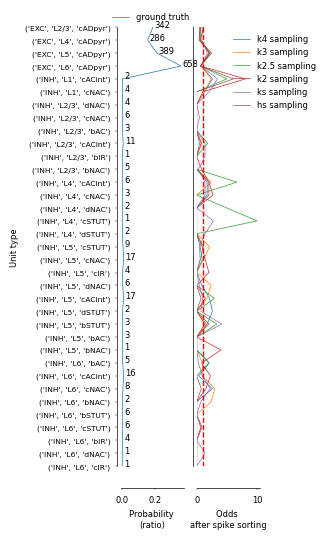

In [89]:
# setup plot
fig, ax = plt.subplots(1, 2, figsize=(1.8, 5.7))
xticks = np.arange(0, len(type_nm["type"]), 1)
gt_unit_dist = count_gt["count"].values / sum(count_gt["count"].values)

# aesthetics
ax[0].plot(
    count_gt["count"].values / sum(count_gt["count"].values),
    xticks,
    label="ground truth",
)
for ix in range(len(count_gt["count"].values)):
    ax[0].text(
        x=gt_unit_dist[ix] + 0.01,
        y=xticks[ix],
        s=str(count_gt["count"].values[ix]),
    )

# odds
ax[1].plot(
    get_odds(count_k4, count_gt),
    xticks,
    label="k4 sampling",
)
ax[1].plot(
    get_odds(count_k3, count_gt),
    xticks,
    label="k3 sampling",
)
ax[1].plot(
    get_odds(count_k25, count_gt),
    xticks,
    label="k2.5 sampling",
)
ax[1].plot(
    get_odds(count_k2, count_gt),
    xticks,
    label="k2 sampling",
)
ax[1].plot(
    get_odds(count_ks, count_gt),
    xticks,
    label="ks sampling",
)
ax[1].plot(
    get_odds(count_hs, count_gt),
    xticks,
    label="hs sampling",
)
ax[1].vlines(x=1, ymin=0, ymax=len(count_gt), color="r", linestyle="--", linewidth=1)

# aesthetics

# disconnected axes
ax[0].set_xlim(left=-1e-2)
ax[0].set_ylim([0, len(count_gt) - 1])
ax[0].set_xlabel("Ground truths")
ax[0].spines["bottom"].set_position(("axes", -0.05))
ax[0].spines["left"].set_position(("axes", -0.05))
# legend
ax[0].set_ylabel("Proportion (ratio)")
ax[0].set_yticks(xticks, type_nm["type"], rotation=0, fontsize=5.4)
ax[0].set_ylabel("Unit type")
ax[0].set_xlabel("Probability \n(ratio)")
ax[0].legend(frameon=False, loc="upper right", bbox_to_anchor=(1.2, 1.05))
ax[0].invert_yaxis()


ax[1].set_xlim(left=-1e-2)
ax[1].set_ylim([0, len(count_gt) - 1])
ax[1].set_xlabel("Ground truths")
ax[1].spines["bottom"].set_position(("axes", -0.05))
ax[1].spines["left"].set_position(("axes", -0.05))
ax[1].set_yticks([])
ax[1].set_xlabel("Odds \nafter spike sorting")
ax[1].legend(frameon=False, loc="upper right", bbox_to_anchor=(2, 1))
ax[1].invert_yaxis()

# save
utils.savefig(
    PROJ_PATH + "/figures/2_biases/assets/fig6G_sampling_bias.svg",
)

In [90]:
def get_sampling_bias_matrix(sorter, bias_df, count_sorting, count_gt, thresh):
    bias_df["type"] = count_gt["type"]
    bias_df[sorter] = 0
    bias_df.loc[np.where(get_odds(count_sorting, count_gt) >= thresh)[0], sorter] = 1
    bias_df.loc[
        np.where(get_odds(count_sorting, count_gt) <= 1 / thresh)[0], sorter
    ] = -1
    return bias_df

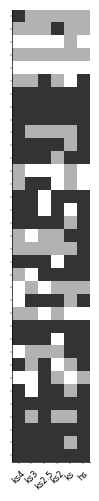

In [93]:
# plot
fig, ax = plt.subplots(figsize=(1, 10))

BIAS_THRESH = 2

bias_df = pd.DataFrame()
bias_df = get_sampling_bias_matrix(
    "ks4", bias_df, count_k4, count_gt, thresh=BIAS_THRESH
)
bias_df = get_sampling_bias_matrix(
    "ks3", bias_df, count_k3, count_gt, thresh=BIAS_THRESH
)
bias_df = get_sampling_bias_matrix(
    "ks2.5", bias_df, count_k25, count_gt, thresh=BIAS_THRESH
)
bias_df = get_sampling_bias_matrix(
    "ks2", bias_df, count_k2, count_gt, thresh=BIAS_THRESH
)
bias_df = get_sampling_bias_matrix(
    "ks", bias_df, count_ks, count_gt, thresh=BIAS_THRESH
)
bias_df = get_sampling_bias_matrix(
    "hs", bias_df, count_hs, count_gt, thresh=BIAS_THRESH
)
sorters = ["ks4", "ks3", "ks2.5", "ks2", "ks", "hs"]

import matplotlib.colors as mcolors

cmap = mcolors.ListedColormap([[0.2, 0.2, 0.2], (0.7, 0.7, 0.7), (1, 1, 1)])

ax.imshow(
    bias_df[sorters].values,
    aspect=1,
    cmap=cmap,
    rasterized=True,  # memory efficiency
)
ax.set_xticks(np.arange(0, len(sorters), 1), sorters)
# ax.set_yticks(np.arange(0, len(count_gt), 1), count_gt["type"], fontsize=5.4)
plt.xticks(rotation=45)
ax.set_yticks(np.arange(0, len(count_gt), 1), [])

# save
utils.savefig_with_params(
    PROJ_PATH + "/figures/2_biases/assets/fig6H_sampling_bias_mx.svg",
    dpi=300,
    transparent=True,
)

utils.savefig_with_params(
    PROJ_PATH + "/figures/2_biases/assets/fig6H_sampling_bias_mx.png",
    dpi=300,
    transparent=True,
)

In [353]:
from scipy.stats import fisher_exact
import matplotlib.pyplot as plt
import numpy as np


def get_table(count_gt, count_k4, target_ix):

    count_gt_i = count_gt["count"].iloc[target_ix]
    count_k4_i = count_k4["count"].iloc[target_ix]
    count_gt_not_i = count_gt["count"].sum() - count_gt["count"].iloc[target_ix]
    count_k4_not_i = count_k4["count"].sum() - count_k4["count"].iloc[target_ix]
    table = pd.DataFrame(
        np.array([[count_gt_i, count_k4_i], [count_gt_not_i, count_k4_not_i]]),
        columns=["ground_truth", "sorter"],
        index=["target", "others"],
    )
    return table


def get_pvalues(count_gt, count_k4):

    pvalues = []
    res_stats = []

    # number of neurons and units
    for ix in range(len(count_gt)):

        # create contingency table
        table = get_table(count_gt, count_k4, ix)

        # collect pvalue
        res_stat, pvalue = fisher_exact(table, alternative="two-sided")
        res_stats.append(res_stat)
        pvalues.append(pvalue)
    return np.array(pvalues)


def get_pvalues_by_unit_type_by_sorter(count_gt, count_by_sorter):
    pvalues_by_sorter = []
    for ix in range(len(count_by_sorter)):
        pvalues_by_sorter.append(get_pvalues(count_gt, count_by_sorter[ix]))
    return np.array(pvalues_by_sorter).T


def get_odds_by_unit_type_by_sorter(count_gt, count_by_sorter):
    odds = []
    for ix in range(len(count_by_sorter)):
        odds.append(get_odds(count_by_sorter[ix], count_gt))
    return np.array(odds).T

### Detailed unit types

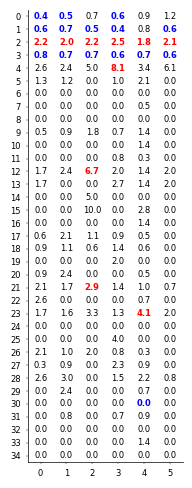

In [371]:
fig, ax = plt.subplots(figsize=(2, 6))

pvalues_by_sorter = []

# odds data
odds_data = get_odds_by_unit_type_by_sorter(count_gt, count_by_sorter)

# pvalues data
pvalue_by_unit_type_by_sorter = get_pvalues_by_unit_type_by_sorter(
    count_gt, count_by_sorter
)

# plot data
df_im = pd.DataFrame(
    [
        count_k4["count"],
        count_k3["count"],
        count_k25["count"],
        count_k2["count"],
        count_ks["count"],
        count_hs["count"],
    ],
    index=["ks4", "ks3", "ks2_5", "ks2", "ks", "hs"],
).T


# Create example data
# data = df_im.values

# Plot the heatmap
cax = ax.imshow(
    np.zeros((odds_data.shape[0], odds_data.shape[1])),
    cmap="binary",
    aspect=0.5,
    rasterized=True,
)


BIAS_THRESH = 1

bias_df = pd.DataFrame()
bias_df = get_sampling_bias_matrix(
    "ks4", bias_df, count_k4, count_gt, thresh=BIAS_THRESH
)
bias_df = get_sampling_bias_matrix(
    "ks3", bias_df, count_k3, count_gt, thresh=BIAS_THRESH
)
bias_df = get_sampling_bias_matrix(
    "ks2.5", bias_df, count_k25, count_gt, thresh=BIAS_THRESH
)
bias_df = get_sampling_bias_matrix(
    "ks2", bias_df, count_k2, count_gt, thresh=BIAS_THRESH
)
bias_df = get_sampling_bias_matrix(
    "ks", bias_df, count_ks, count_gt, thresh=BIAS_THRESH
)
bias_df = get_sampling_bias_matrix(
    "hs", bias_df, count_hs, count_gt, thresh=BIAS_THRESH
)

bias_direction = bias_df.drop(columns="type").values

# Annotate each cell with its value
for i in range(odds_data.shape[0]):  # Rows
    for j in range(odds_data.shape[1]):  # Columns

        # color statistical significance and direction of selection bias
        if (pvalue_by_unit_type_by_sorter[i, j] < 0.05) & (bias_direction[i, j] == 1):
            pvalue_color = "red"
            weight = "bold"
        elif (pvalue_by_unit_type_by_sorter[i, j] < 0.05) & (
            bias_direction[i, j] == -1
        ):
            pvalue_color = "blue"
            weight = "bold"
        else:
            pvalue_color = [0, 0, 0]
            weight = None

        # annotate the odds after spike sorting
        ax.text(
            j,
            i,
            f"{np.round(odds_data[i, j],1)}",
            ha="center",
            va="center",
            color=pvalue_color,
            weight=weight,
        )

# Set axis labels
ax.set_xticks(range(odds_data.shape[1]))
ax.set_yticks(range(odds_data.shape[0]))
# ax.set_xticklabels(["A", "B", "C"])
# ax.set_yticklabels(["X", "Y", "Z"])

utils.savefig_with_params(
    PROJ_PATH + "/figures/2_biases/assets/fig6H_sampling_bias_mx_pvalues.png",
    dpi=300,
    transparent=True,
)

In [381]:
# ratio of pyramidal cells
proportion_of_excitatory_neurons = (
    count_gt["count"].iloc[:4].sum() / count_gt["count"].sum()
)
proportion_of_excitatory_neurons

0.9123093681917211

### Plot unit types by quality

In [18]:
# parameters
df_all = [df_k4, df_k3, df_k25, df_k2, df_ks, df_hs]
sorters = ["KS4", "KS3", "KS2.5", "KS2", "KS", "HS"]

# compute unit type distribution by spike sorter
count_g, count_oo = feat.count_unit_type_by_quality(
    df_all, sorters, unique_type_feat, unique_type
)

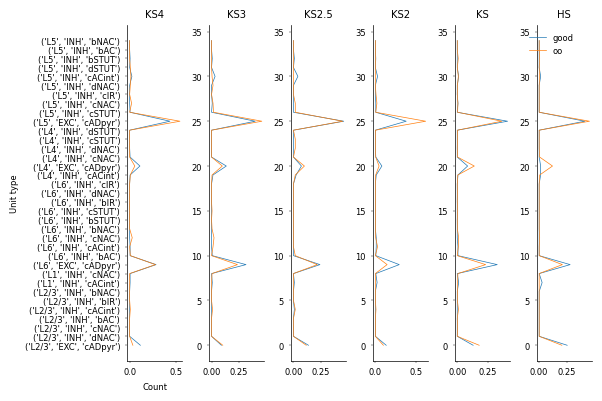

In [19]:
# plot raw count
fig, ax = plt.subplots(1, len(count_g.keys()), figsize=(6, 4))

# loop over spike sorter
for ix in range(len(count_g.keys())):

    ticks = np.arange(0, len(type_nm), 1)

    # aesthetics
    if ix == 0:
        ax[ix].set_yticks(xticks, type_nm["type"], rotation=0)
        ax[ix].set_xlabel("Count")
        ax[ix].set_ylabel("Unit type")

    # proportions
    # mixed: good
    ax[ix].plot(
        count_g[sorters[ix]]["count"].values
        / sum(count_g[sorters[ix]]["count"].values),
        xticks,
        label="good",
    )

    # poor: overmerger + oversplitter
    ax[ix].plot(
        count_oo[sorters[ix]]["count"].values
        / sum(count_oo[sorters[ix]]["count"].values),
        xticks,
        label="oo",
    )
    if ix == len(count_g.keys()) - 1:
        ax[ix].legend(frameon=False, loc="upper right", bbox_to_anchor=(0.8, 1))
    ax[ix].set_title(sorters[ix])

plt.tight_layout()